In [1]:
#Exercise: Tackle the Titanic dataset. A great place to start is on Kaggle. Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. 
#This will give you two CSV files: _train.csv and test.csv which you can load using pandas.read_csv().
#The goal is to train a classifier that can predict the Survived column based on the other columns._
#The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.



In [2]:
#Let's fetch the data and load it:

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [17]:
train_data, test_data = load_titanic_data()

In [18]:
train_data.head()


#PassengerId: a unique identifier for each passenger
#Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
#Pclass: passenger class.
#Name, Sex, Age: self-explanatory
#SibSp: how many siblings & spouses of the passenger aboard the Titanic.
#Parch: how many children & parents of the passenger aboard the Titanic.
#Ticket: ticket id
#Fare: price paid (in pounds)
#Cabin: passenger's cabin number
#Embarked: where the passenger embarked the Titanic


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

#set PassengerId as index

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [21]:
train_data[train_data["Sex"]=="female"]["Age"].median()

#The Age attribute has about 19% null values
#Replacing null values with the median age

27.0

In [22]:
#Let's take a look at numerical attributes

train_data.describe()

#Only 38% Survived! 😭 That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
#The mean Fare was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
#The mean Age was less than 30 years old.

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [23]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [24]:
#let's take a quick look at all the categorical attributes:

train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [25]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [26]:
train_data["Embarked"].value_counts()

#where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.


Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [30]:
#let's build our preprocessing pipelines, starting with the pipeline for numerical attributes:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler  # Add this line

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [31]:
#Now we can build the pipeline for the categorical attributes:

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [32]:
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

In [33]:
#let's join the numerical and categorical pipelines:

from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])


In [34]:
#let's feed training data into the pipeline

X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [35]:
#labels

y_train = train_data["Survived"]

In [38]:
#Let's train the classifiers starting with RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [39]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

In [41]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

In [47]:
#Let's try an SVC:

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

#Great! This model looks better.

0.8249313358302123

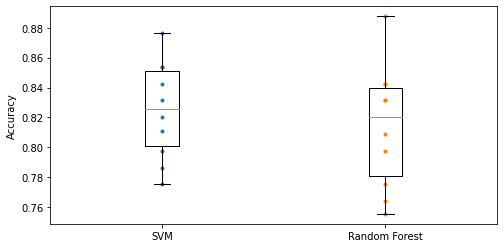

In [49]:
#et's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles
#and "whiskers" showing the extent of the scores

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

#Note that the boxplot() function detects outliers (called "fliers") and does not include them within the whiskers.
#Specifically, if the lower quartile is  𝑄1  and the upper quartile is  𝑄3 , then the interquartile range  𝐼𝑄𝑅=𝑄3−𝑄1  (this is the box's height)
#and any score lower than  𝑄1−1.5×𝐼𝑄𝑅  is a flier, and so is any score greater than  𝑄3+1.5×𝐼𝑄𝑅 .

#The random forest classifier got a very high score on one of the 10 folds, but overall it had a lower mean score, as well as a bigger spread, 
#so it looks like the SVM classifier is more likely to generalize well.

In [50]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [51]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000
